In [1]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
import time

model_name = "PE_classification_224_160_48_1_3_d.h5"

# Nicely formatted time string
def hms_string(sec_elapsed):
    h = int(sec_elapsed / (60 * 60))
    m = int((sec_elapsed % (60 * 60)) / 60)
    s = sec_elapsed % 60
    return "{}:{:>02}:{:>05.2f}".format(h, m, s)


#The folder path for train non-PE

normal_scan_paths_train = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE0415/train/nr", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/train/nr")
]

#The folder path for val non-PE

normal_scan_paths_val = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE0415/val/nr", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/val/nr")
]

#The folder path for train PE

abnormal_scan_paths_train = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE0415/train/pe", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/train/pe")
]

#The folder path for non-PE

abnormal_scan_paths_val = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE0415/val/pe", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/val/pe")
]


total_nr= int(len(normal_scan_paths_train)) +  int(len(normal_scan_paths_val))
total_pe= int(len(abnormal_scan_paths_train)) + int(len(abnormal_scan_paths_val))

print("CT scans with normal lung tissue: " + str(total_nr))
print("CT scans with abnormal lung tissue: " + str(total_pe))


####################################################

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
#   Read and load volume
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


abnormal_scans_train = np.array([read_nifti_file(path) for path in abnormal_scan_paths_train])
normal_scans_train = np.array([read_nifti_file(path) for path in normal_scan_paths_train])

abnormal_scans_val = np.array([read_nifti_file(path) for path in abnormal_scan_paths_val])
normal_scans_val = np.array([read_nifti_file(path) for path in normal_scan_paths_val])

nr100_train = round(len(normal_scan_paths_train)  )
pe100_train = round(len(abnormal_scan_paths_train)  )
nr100_val = round(len(normal_scan_paths_val)  )
pe100_val = round(len(abnormal_scan_paths_val)   )


#nr70 = round(len(normal_scan_paths) * 0.7 )
#nr30 = len(normal_scan_paths) - nr70
#pe70 = round(len(abnormal_scan_paths) * 0.7 )
#pe30 = len(abnormal_scan_paths) - pe70

#print("nr70%:",nr70,"nr30%",nr30)
#print("pe70%:",pe70,"pe30%:",pe30)

# For the CT scans having Pulmonary embolism
# assign 1, for the normal and other disease ones assign 0.
abnormal_labels_train = np.array([1 for _ in range(len(abnormal_scans_train))])
normal_labels_train = np.array([0 for _ in range(len(normal_scans_train))])

abnormal_labels_val = np.array([1 for _ in range(len(abnormal_scans_val))])
normal_labels_val = np.array([0 for _ in range(len(normal_scans_val))])


# Split data in the ratio 70-30 for training and validation.
x_train = np.concatenate((abnormal_scans_train[:pe100_train], normal_scans_train[:nr100_train]), axis=0)
y_train = np.concatenate((abnormal_labels_train[:pe100_train], normal_labels_train[:nr100_train]), axis=0)
x_val = np.concatenate((abnormal_scans_val[:pe100_val], normal_scans_val[:nr100_val]), axis=0)
y_val = np.concatenate((abnormal_labels_val[:pe100_val], normal_labels_val[:nr100_val]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train.shape[0], x_val.shape[0])
)



CT scans with normal lung tissue: 144
CT scans with abnormal lung tissue: 136
Number of samples in train and validation are 240 and 40.


In [2]:

####################################################
def x_shift(volume):
    def scipy_x_shift(volume):
    
        min_shift = 15
        max_shift = 30
    
#        if random.randint(1,100) > 30:
#            return volume
        shift_dir = 1
        if random.randint(1,100) > 50:

            shift_dir = -1
        roll_amount = random.randint(min_shift, max_shift)

        roll_amount *= shift_dir

        volume = np.roll(volume, roll_amount, axis=0)
        #z,y,x?
        if shift_dir > 0:
            volume[0:roll_amount,:, :] = 0
        else:
            volume[roll_amount:,:, :] = 0

        return volume

    augmented_volume = tf.numpy_function(scipy_x_shift, [volume], tf.float64)
    return augmented_volume



def y_shift(volume):
    def scipy_y_shift(volume):
    
        min_shift = 15
        max_shift = 30
    
#        if random.randint(1,100) > 30:

#            return volume
        shift_dir = 1
        if random.randint(1,100) > 50:

            shift_dir = -1
        roll_amount = random.randint(min_shift, max_shift)

        roll_amount *= shift_dir
        volume = np.roll(volume, roll_amount, axis=1)
        #z,y,x?
        if shift_dir > 0:
            volume[:, 0:roll_amount, :] = 0
        else:
            volume[:, roll_amount: , :] = 0

        return volume

    augmented_volume = tf.numpy_function(scipy_y_shift, [volume], tf.float64)
    return augmented_volume




from scipy.ndimage import gaussian_filter

def blur_3d(volume):
    def scipy_aussian_blur_3d(volume):
        if random.randint(1,100) > 50:
            return volume
        sigma = random.uniform(0.1,0.9)
        volume = gaussian_filter(volume, sigma=sigma)
        return volume

    augmented_volume = tf.numpy_function(scipy_aussian_blur_3d, [volume], tf.float64)
    return augmented_volume


def x_flip(volume):
    def scipy_x_flip(volume):
        if random.randint(1,100) > 100:
            volume = volume[::-1,:, :]
        else:
            volume = volume
        return volume

    augmented_volume = tf.numpy_function(scipy_x_flip, [volume], tf.float64)
    return augmented_volume


def y_flip(volume):
    def scipy_y_flip(volume):
        if random.randint(1,100) > 50:
            volume = volume[:, ::-1, :]
        else:
            volume = volume
        return volume 

    augmented_volume = tf.numpy_function(scipy_y_flip, [volume], tf.float64)
    return augmented_volume


######################################


import random
from scipy import ndimage



@tf.function
def rotate(volume):
    """Rotate the volume by a few degrees"""

    def scipy_rotate(volume):
        # define some rotation angles
        angles = [-10, -7, -5, 5, 7, 10]
        # pick angles at random
        angle = random.choice(angles)
        # rotate volume
        volume = ndimage.rotate(volume, angle, reshape=False)
        volume[volume < 0] = 0
        volume[volume > 1] = 1
        return volume

    augmented_volume = tf.numpy_function(scipy_rotate, [volume], tf.float64)
    return augmented_volume


def train_preprocessing(volume, label):
    """Process training data by rotating and adding a channel."""
    # Rotate volume

    volume = x_flip(volume)    
    volume = y_flip(volume)   
    volume = x_shift(volume)
    volume = y_shift(volume)
    volume = rotate(volume)
    volume = blur_3d(volume)
    volume = tf.expand_dims(volume, axis=3)
    return volume, label


def validation_preprocessing(volume, label):
    """Process validation data by only adding a channel."""
    volume = tf.expand_dims(volume, axis=3)
    return volume, label

####################################################

from tensorflow.python.client import device_lib

def get_available_gpus():
    local_device_protos = device_lib.list_local_devices()
    return [x.name for x in local_device_protos if x.device_type == 'GPU']

get_available_gpus()

####################################################


['/device:GPU:0', '/device:GPU:1']

In [3]:
# Define data loaders.
train_loader = tf.data.Dataset.from_tensor_slices((x_train, y_train))
validation_loader = tf.data.Dataset.from_tensor_slices((x_val, y_val))

batch_size = 4
# Augment the  on the fly during training.
train_dataset = (    
    train_loader.shuffle(len(x_train))
    .map(train_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)
# Only rescale.
validation_dataset = (
    validation_loader.shuffle(len(x_val))
    .map(validation_preprocessing)
    .batch(batch_size)
    .prefetch(2)
)

####################################################

Dimension of the CT scan is: (224, 160, 48, 1)


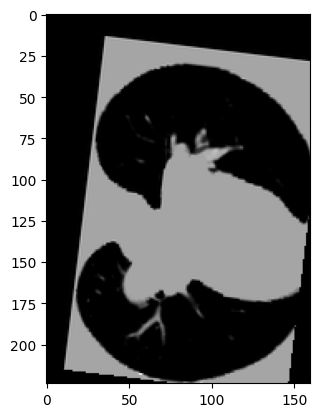

In [4]:
import matplotlib.pyplot as plt

data = train_dataset.take(1)
images, labels = list(data)[0]
images = images.numpy()
image = images[0]
print("Dimension of the CT scan is:", image.shape)
plt.imshow(np.squeeze(image[:, :, 30]), cmap="gray")

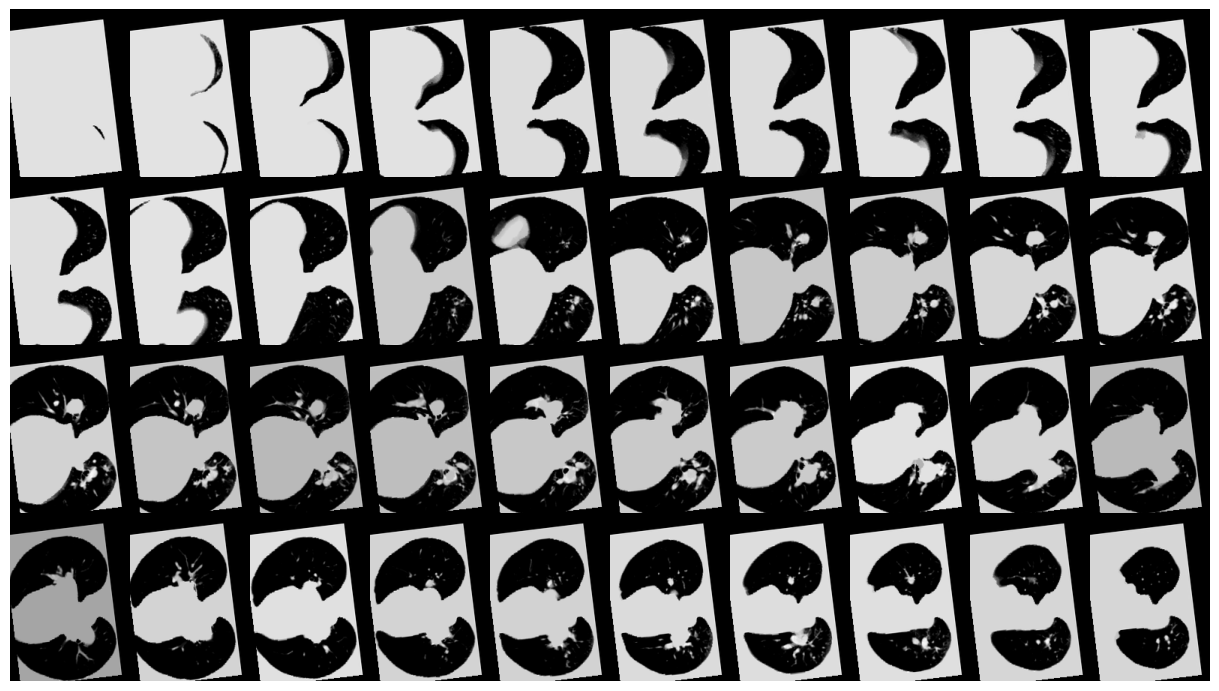

In [5]:
def plot_slices(num_rows, num_columns, width, height, data):
    """Plot a montage of 20 CT slices"""
    data = np.rot90(np.array(data))
    data = np.transpose(data)
    data = np.reshape(data, (num_rows, num_columns, width, height))
    rows_data, columns_data = data.shape[0], data.shape[1]
    heights = [slc[0].shape[0] for slc in data]
    widths = [slc.shape[1] for slc in data[0]]
    fig_width = 12.0
    fig_height = fig_width * sum(heights) / sum(widths)
    f, axarr = plt.subplots(
        rows_data,
        columns_data,
        figsize=(fig_width, fig_height),
        gridspec_kw={"height_ratios": heights},
    )
    for i in range(rows_data):
        for j in range(columns_data):
            axarr[i, j].imshow(data[i][j], cmap="gray")
            axarr[i, j].axis("off")
    plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
    plt.show()


# Visualize montage of slices.
# 4 rows and 10 columns for 100 slices of the CT scan.
plot_slices(4, 10, 224, 160, image[:, :, :40])

In [6]:
from keras.utils import np_utils
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import binary_crossentropy
from keras.optimizers import Adadelta, SGD
from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
from keras.models import Model
import cv2
import time
import os
import numpy as np
import keras
import h5py
import numpy as np
from keras import regularizers
import os
import glob
import cv2
import random
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_curve, roc_auc_score
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, CSVLogger, EarlyStopping, ReduceLROnPlateau
from keras.models import Sequential
from keras.optimizers import RMSprop
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras import optimizers
from keras.utils import to_categorical, plot_model
from keras.layers import Dense, Input, Conv2D, Flatten, MaxPooling2D, Activation
from keras.models import Model, Sequential
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.models import load_model
from keras.utils import np_utils
from keras import backend as K
from keras.models import load_model
import keras
import tensorflow as tf

def get_model():
    
    input_layer = Input((224, 160, 48, 1))
    
    conv_layer1 = Conv3D(filters=128, kernel_size=(3, 3, 3), activation='relu')(input_layer)
    pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer1)
    pooling_layer1 = BatchNormalization()(pooling_layer1) 
    
    
    conv_layer2 = Conv3D(filters=256, kernel_size=(3, 3, 3), activation='relu')(pooling_layer1)
    pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)
    pooling_layer2 = BatchNormalization()(pooling_layer2)  
    
    
    conv_layer3 = Conv3D(filters=512, kernel_size=(3, 3, 3), activation='relu')(pooling_layer2)
    pooling_layer3 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer3)
    pooling_layer3 = BatchNormalization()(pooling_layer3)
    
    conv_layer4 = Conv3D(filters=1024, kernel_size=(3, 3, 3), activation='relu')(pooling_layer3)
    pooling_layer4 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)
    pooling_layer4 = BatchNormalization()(pooling_layer4)
    
    flatten_layer = Flatten()(pooling_layer4)
    

    dense_layer4 = Dense(units=2048, activation='relu')( flatten_layer)
    dense_layer4 = Dropout(0.4)(dense_layer4)
    
    dense_layer5 = Dense(units=1024, activation='relu')(dense_layer4)
    dense_layer5 = Dropout(0.4)(dense_layer5)

    output_layer = Dense(units=1, activation="sigmoid")(dense_layer5)
    
    model = Model(inputs=input_layer, outputs=output_layer, name="3dcnn")
    
    return model

model = None
model = get_model()
model.summary()

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d (Conv3D)             (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 111, 79, 23, 128)  0        
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 111, 79, 23, 128)  512      
 ormalization)                                                   
                                                                 
 conv3d_1 (Conv3D)           (None, 109, 77, 21, 256)  884992

In [7]:
from tensorflow.python.client import device_lib
devices = device_lib.list_local_devices()

def sizeof_fmt(num, suffix='B'):
    for unit in ['','Ki','Mi','Gi','Ti','Pi','Ei','Zi']:
        if abs(num) < 1024.0:
            return "%3.1f %s%s" % (num, unit, suffix)
        num /= 1024.0
    return "%.1f%s%s" % (num, 'Yi', suffix)

for d in devices:
    t = d.device_type
    name = d.physical_device_desc
    l = [item.split(':',1) for item in name.split(", ")]
    name_attr = dict([x for x in l if len(x)==2])
    dev = name_attr.get('name', 'Unnamed device')
    print(f" {d.name} || {dev} || {t} || {sizeof_fmt(d.memory_limit)}")

#strategy = tf.distribute.MirroredStrategy( GPUS )
strategy = tf.distribute.MirroredStrategy( devices=["GPU:0" , "GPU:1"], cross_device_ops=tf.distribute.HierarchicalCopyAllReduce()) 
print('Number of devices: %d' % strategy.num_replicas_in_sync) 

#batch_size = BATCH_SIZE * strategy.num_replicas_in_sync    
    


 /device:CPU:0 || Unnamed device || CPU || 256.0 MiB
 /device:GPU:0 ||  NVIDIA GeForce RTX 3090 || GPU || 21.2 GiB
 /device:GPU:1 ||  NVIDIA GeForce RTX 3090 || GPU || 21.2 GiB
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1')
Number of devices: 2


In [8]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():

    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)

# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

In [10]:


from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()

# Compile model.
initial_learning_rate = 0.0001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():

    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"])


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
model.load_weights(model_name)
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 111, 79, 23, 128)  0        
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 111, 79, 23, 128)  512      
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 109, 77, 21, 256)  884992

KeyboardInterrupt: 

In [ ]:

from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()

# Compile model.
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():

    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"])


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
model.load_weights(model_name)
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d_12 (Conv3D)          (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 111, 79, 23, 128)  0        
 g3D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 111, 79, 23, 128)  512      
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 109, 77, 21, 256)  884992

In [8]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()


# Compile model.
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():

    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"])


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
model.load_weights(model_name)
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Redu

Epoch 27/100
131/131 - 89s - loss: 0.5709 - acc: 0.7228 - val_loss: 0.6874 - val_acc: 0.6500 - 89s/epoch - 679ms/step
Epoch 28/100
131/131 - 90s - loss: 0.5408 - acc: 0.7132 - val_loss: 0.7339 - val_acc: 0.6500 - 90s/epoch - 684ms/step
Training time: 0:41:44.79


In [10]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()


# Compile model.
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():

    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"])


# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
model.load_weights(model_name)
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d_12 (Conv3D)          (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_12 (MaxPoolin  (None, 111, 79, 23, 128)  0        
 g3D)                                                            
                                                                 
 batch_normalization_12 (Bat  (None, 111, 79, 23, 128)  512      
 chNormalization)                                                
                                                                 
 conv3d_13 (Conv3D)          (None, 109, 77, 21, 256)  884992

KeyboardInterrupt: 

In [9]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()


# Compile model.
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():
#    model = get_model(width=128, height=128, depth=128)
    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"])




# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
model.load_weights(model_name)
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d_8 (Conv3D)           (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_8 (MaxPooling  (None, 111, 79, 23, 128)  0        
 3D)                                                             
                                                                 
 batch_normalization_8 (Batc  (None, 111, 79, 23, 128)  512      
 hNormalization)                                                 
                                                                 
 conv3d_9 (Conv3D)           (None, 109, 77, 21, 256)  884992

In [11]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()


# Compile model.
initial_learning_rate = 0.000001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():

    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"])






# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
model.load_weights(model_name)
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d_16 (Conv3D)          (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_16 (MaxPoolin  (None, 111, 79, 23, 128)  0        
 g3D)                                                            
                                                                 
 batch_normalization_16 (Bat  (None, 111, 79, 23, 128)  512      
 chNormalization)                                                
                                                                 
 conv3d_17 (Conv3D)          (None, 109, 77, 21, 256)  884992

In [12]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()


# Compile model.
initial_learning_rate = 0.0000001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():
#    model = get_model(width=128, height=128, depth=128)
    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"])



# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
model.load_weights(model_name)
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d_20 (Conv3D)          (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 111, 79, 23, 128)  0        
 g3D)                                                            
                                                                 
 batch_normalization_20 (Bat  (None, 111, 79, 23, 128)  512      
 chNormalization)                                                
                                                                 
 conv3d_21 (Conv3D)          (None, 109, 77, 21, 256)  884992

In [13]:
from tensorflow import keras
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import schedules

start = time.time()


# Compile model.
initial_learning_rate = 0.00001
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)


with strategy.scope():

    model = get_model()
    model.summary()
    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=lr_schedule),
        metrics=["acc"])



# Define callbacks.
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    model_name, save_best_only=True
)


early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_acc", patience=15)
model.load_weights(model_name)
# Train the model, doing validation at the end of each epoch
epochs = 100
model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=epochs,
    shuffle=True,
    verbose=2,  
    callbacks=[checkpoint_cb, early_stopping_cb],
)

elapsed = time.time()-start
print (f'Training time: {hms_string(elapsed)}')

Model: "3dcnn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 160, 48, 1)  0         
                             ]                                   
                                                                 
 conv3d_24 (Conv3D)          (None, 222, 158, 46, 128  3584      
                             )                                   
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 111, 79, 23, 128)  0        
 g3D)                                                            
                                                                 
 batch_normalization_24 (Bat  (None, 111, 79, 23, 128)  512      
 chNormalization)                                                
                                                                 
 conv3d_25 (Conv3D)          (None, 109, 77, 21, 256)  884992

KeyboardInterrupt: 

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1, 2, figsize=(20, 3))
ax = ax.ravel()

for i, metric in enumerate(["acc", "loss"]):
    ax[i].plot(model.history.history[metric])
    ax[i].plot(model.history.history["val_" + metric])
    ax[i].set_title("Model {}".format(metric))
    ax[i].set_xlabel("epochs")
    ax[i].set_ylabel(metric)
    ax[i].legend(["train", "val"])

In [ ]:
import numpy as np
import pandas as pd
import csv

df = pd.DataFrame(columns = ["predict", "actual"])


abnormal_correct = 0
abnormal_wrong = 0
other_correct = 0
other_wrong = 0
for patient in range (0,len(y_train)): 
# Load best weights.

    model.load_weights(model_name)
    prediction = model.predict(np.expand_dims(x_train[patient], axis=0))[0]
    label_1 = y_train[patient]
    
    scores = [1 - prediction[0], prediction[0]]
    print(label_1)
    if (prediction[0] > 0.50) & (label_1 == 1) :
        abnormal_correct = abnormal_correct + 1
    if (prediction[0] > 0.50) & (label_1 == 0) :
        abnormal_wrong = abnormal_wrong + 1
    if (prediction[0] < 0.50) & (label_1 == 0) :
        other_correct = other_correct + 1
    if (prediction[0] < 0.50) & (label_1 == 1) :
        other_wrong = other_wrong + 1
        
    prediction_score = prediction[0]     
        
    df = df.append({'predict' : prediction_score , 'actual' : label_1 },
        ignore_index = True)        
        
        
  
        
#    print (abnormal_correct,other_wrong,other_correct,abnormal_wrong )    
        

    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names):
        print(
            "This model is %.2f percent confident that CT scan is %s"
            % ((100 * score), name)
        )
        
        
        
print(df) 

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Y_pred = model.predict(x_val)
disease_types=['PE', 'non-PE']



#Y_pred = np.argmax(Y_pred, axis=1)
#Y_true = y_val
#Y_true = np.argmax(y_val,axis=1)
#print (Y_pred)
#print (Y_true)
#cm = confusion_matrix(Y_true, Y_pred)

cm = [[abnormal_correct,abnormal_wrong],[other_wrong,other_correct]]

plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# 讀取資料
import pandas as pd
#df=pd.read_csv('./AUC.csv')

# 在各種『決策門檻』（decision threshold）下，計算 『真陽率』（True Positive Rate；TPR）與『假陽率』（False Positive Rate；FPR）
fpr, tpr, threshold = roc_curve(df['actual'], df['predict'])
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

In [ ]:
[[abnormal_correct,abnormal_wrong],[other_wrong,other_correct]]

TP = abnormal_correct
FP = abnormal_wrong
TN = other_correct
FN = other_wrong

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

F1_score = ((Precision*Recall)/(Precision+Recall))*2

Accuracy = (TP+TN)/(TP+FP+TN+FN)

print ("Precision",Precision)
print ("Recall",Recall)
print ("F1_score",F1_score)
print ("Accuracy",Accuracy)

In [ ]:
import warnings 
warnings.simplefilter(action='ignore',category=FutureWarning)

In [ ]:
import numpy as np
import pandas as pd
import csv


abnormal_correct = 0
abnormal_wrong = 0
other_correct = 0
other_wrong = 0

df2 = pd.DataFrame(columns = ["predict", "actual"])

for patient in range (0,len(y_val)):
    

    
# Load best weights.

    model.load_weights(model_name)
    prediction = model.predict(np.expand_dims(x_val[patient], axis=0))[0]
    label_1 = y_val[patient]
    
    scores = [1 - prediction[0], prediction[0]]
    print(label_1)
    if (prediction[0] > 0.5) & (label_1 == 1) :
        abnormal_correct = abnormal_correct + 1
    if (prediction[0] > 0.5) & (label_1 == 0) :
        abnormal_wrong = abnormal_wrong + 1
    if (prediction[0] < 0.5) & (label_1 == 0) :
        other_correct = other_correct + 1
    if (prediction[0] < 0.5) & (label_1 == 1) :
        other_wrong = other_wrong + 1        

    prediction_score = prediction[0] *100        
        
    df2 = df2.append({'predict' : prediction_score , 'actual' : label_1 },
        ignore_index = True)           
    
        
#    print (abnormal_correct,other_wrong,other_correct,abnormal_wrong )    
        

    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names):
        print(
            "This model is %.2f percent confident that CT scan is %s"
            % ((100 * score), name)
        )
        
#        print (prediction[0])
print(df2) 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# 讀取資料
import pandas as pd
#df=pd.read_csv('./AUC.csv')

# 在各種『決策門檻』（decision threshold）下，計算 『真陽率』（True Positive Rate；TPR）與『假陽率』（False Positive Rate；FPR）
fpr, tpr, threshold = roc_curve(df2['actual'], df2['predict'])
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()    

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
#Y_pred = model.predict(x_val)
disease_types=['PE', 'non-PE']



#Y_pred = np.argmax(Y_pred, axis=1)
#Y_true = y_val
#Y_true = np.argmax(y_val,axis=1)
#print (Y_pred)
#print (Y_true)
#cm = confusion_matrix(Y_true, Y_pred)

cm = [[abnormal_correct,abnormal_wrong],[other_wrong,other_correct]]

plt.figure(figsize=(12, 12))
ax = sns.heatmap(cm, cmap=plt.cm.Greens, annot=True, square=True, xticklabels=disease_types, yticklabels=disease_types)
ax.set_ylabel('Actual', fontsize=40)
ax.set_xlabel('Predicted', fontsize=40)

In [ ]:
[[abnormal_correct,abnormal_wrong],[other_wrong,other_correct]]

TP = abnormal_correct
FP = abnormal_wrong
TN = other_correct
FN = other_wrong

Precision = TP/(TP+FP)

Recall = TP/(TP+FN)

F1_score = ((Precision*Recall)/(Precision+Recall))*2

Accuracy = (TP+TN)/(TP+FP+TN+FN)

print ("Precision",Precision)
print ("Recall",Recall)
print ("F1_score",F1_score)
print ("Accuracy",Accuracy)

In [ ]:
import os
import zipfile
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers 
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense

# Folder "nr_128_64" consist of CT scans having normal lung tissue or other lung disease

normal_scan_paths2 = [
    os.path.join(os.getcwd(), "C:/Users/85298/AI/PE0415/test/nr", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/test/nr")
]
# Folder "pe_128_64" consist of CT scans having Pulmonary embolism,

abnormal_scan_paths2 = [
    os.path.join(os.getcwd(),"C:/Users/85298/AI/PE0415/test/pe", x)
    for x in os.listdir("C:/Users/85298/AI/PE0415/test/pe")
]

print("CT scans with normal lung tissue: " + str(len(normal_scan_paths2)))
print("CT scans with abnormal lung tissue: " + str(len(abnormal_scan_paths2)))


####################################################

import nibabel as nib

from scipy import ndimage


def read_nifti_file(filepath):
#   Read and load volume
    # Read file
    scan = nib.load(filepath)
    # Get raw data
    scan = scan.get_fdata()
    return scan


abnormal_scans2 = np.array([read_nifti_file(path) for path in abnormal_scan_paths2])
normal_scans2 = np.array([read_nifti_file(path) for path in normal_scan_paths2])

nr100 = round(len(normal_scan_paths2)  )
pe100 = round(len(abnormal_scan_paths2)   )


#print("nr70%:",nr70,"nr30%",nr30)
#print("pe70%:",pe70,"pe30%:",pe30)

# For the CT scans having Pulmonary embolism
# assign 1, for the normal and other disease ones assign 0.
abnormal_labels2 = np.array([1 for _ in range(len(abnormal_scans2))])
normal_labels2 = np.array([0 for _ in range(len(normal_scans2))])

# Split data in the ratio 70-30 for training and validation.
x_train2 = np.concatenate((abnormal_scans2[:pe100], normal_scans2[:nr100]), axis=0)
y_train2 = np.concatenate((abnormal_labels2[:pe100], normal_labels2[:nr100]), axis=0)
x_val2 = np.concatenate((abnormal_scans2[pe100:], normal_scans2[nr100:]), axis=0)
y_val2 = np.concatenate((abnormal_labels2[pe100:], normal_labels2[nr100:]), axis=0)
print(
    "Number of samples in train and validation are %d and %d."
    % (x_train2.shape[0], x_val2.shape[0])
)


####################################################


In [ ]:
import numpy as np
import pandas as pd
import csv


abnormal_correct = 0
abnormal_wrong = 0
other_correct = 0
other_wrong = 0

df_out = pd.DataFrame(columns = ["predict", "actual"])

for patient in range (0,len(y_train2)):
    

# Load best weights.

#    model.load_weights("C:/Users/85298/AI/PE0210/backup_model/PE_classification_128_128_b.h5")
    model.load_weights(model_name)
    prediction = model.predict(np.expand_dims(x_train2[patient], axis=0))[0]
    label_1 = y_train2[patient]
    
    scores = [1 - prediction[0], prediction[0]]
    print(label_1)
    if (prediction[0] > 0.01) & (label_1 == 1) :
        abnormal_correct = abnormal_correct + 1
    if (prediction[0] > 0.01) & (label_1 == 0) :
        abnormal_wrong = abnormal_wrong + 1
    if (prediction[0] < 0.01) & (label_1 == 0) :
        other_correct = other_correct + 1
    if (prediction[0] < 0.01) & (label_1 == 1) :
        other_wrong = other_wrong + 1        
        
    prediction_score = prediction[0] *100        
        
    df_out = df_out.append({'predict' : prediction_score , 'actual' : label_1 },
        ignore_index = True)                   
    
        
    print (abnormal_correct,other_wrong,other_correct,abnormal_wrong )    
        

    class_names = ["normal", "abnormal"]
    for score, name in zip(scores, class_names):
        print(
            "This model is %.2f percent confident that CT scan is %s"
            % ((100 * score), name)
        )
        
print (df_out)




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, auc

# 讀取資料
import pandas as pd
#df=pd.read_csv('./AUC.csv')

# 在各種『決策門檻』（decision threshold）下，計算 『真陽率』（True Positive Rate；TPR）與『假陽率』（False Positive Rate；FPR）
fpr, tpr, threshold = roc_curve(df_out['actual'], df_out['predict'])
print(fpr, tpr, threshold)

auc1 = auc(fpr, tpr)
## Plot the result
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, color = 'orange', label = 'AUC = %0.2f' % auc1)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()   